On the occasion of the 2017 playoffs:

 1. Can we predict Stephen Curry's shot outcome?
 2. If so - can we build a model that would help Stephen improve is field goals?
 3. Or, alternatively, can we give the basic guidelines for a naive AI basketball player for when to shot?
 4. And would the Warriors redeem themselves this year?

I will try to answer questions 1-3 in this script.


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('fivethirtyeight')

from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re
from sklearn.model_selection import train_test_split
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

shot_logs.csv



Read the Data and calculate Curry's field goals:

In [2]:
shots = pd.read_csv('../input/shot_logs.csv')
player_name = 'stephen curry'
player_df = shots[shots.player_name == player_name]
print(np.true_divide(len(player_df[player_df.FGM == 1]),len(player_df)))

0.485537190083


Curry's field goals percents are 48%, which means the most naive classifier that would assume all Curry's shot are out (and what a mistake that would be) would acheive an accuracy of 52%. Let's see how a decision tree is compared to this benchmark

Let's also visualize the tree using the great graphviz library:

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.6/site-pack

0.575562700965


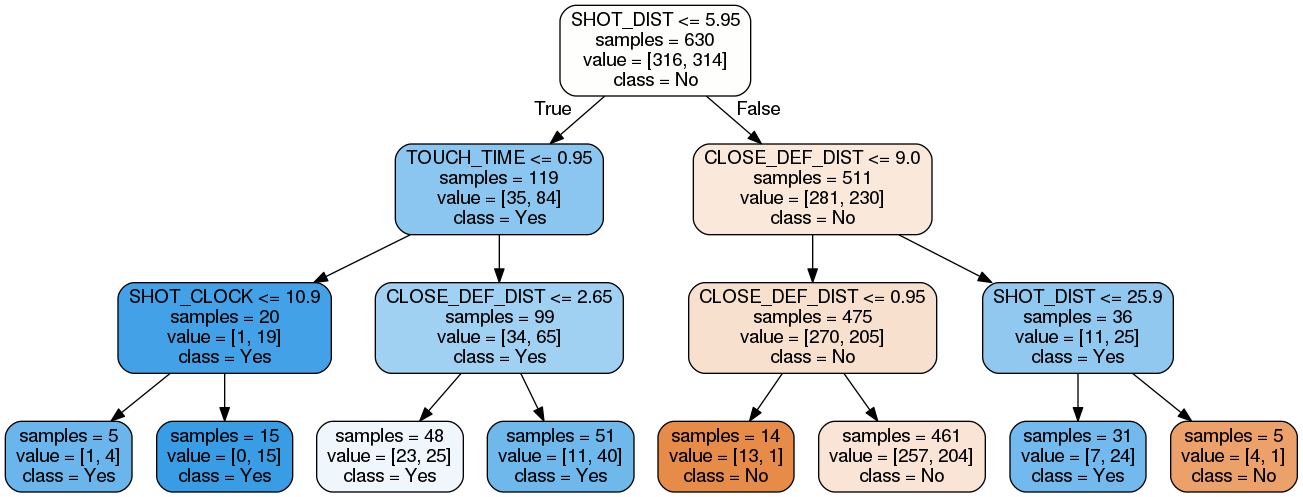

In [3]:
player_df['LOCATION'][player_df.LOCATION == 'H'] = 1
player_df['LOCATION'][player_df.LOCATION == 'A'] = 0

player_df = player_df.drop(['GAME_ID','MATCHUP','W','FINAL_MARGIN','SHOT_RESULT', 'CLOSEST_DEFENDER_PLAYER_ID','GAME_CLOCK','player_name','player_id','PTS','CLOSEST_DEFENDER'], axis = 1)
player_df = player_df[~np.isnan(player_df.SHOT_CLOCK) == True ]

X_train, X_test, y_train, y_test = train_test_split(
     player_df.drop(['FGM'], axis = 1), player_df.FGM, test_size=0.33, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth = 3,min_samples_leaf = 5)
decision_tree.fit(X_train, y_train)


y_pred = decision_tree.predict(X_test)

diff = y_pred - y_test
print(np.true_divide(len(diff[diff == 0]),len(y_test)))


with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 5,
                              impurity = False,
                              feature_names = X_test.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png")

There are a few leafs/buckets with low gini coefficient:

 - for shot distance<5.95 feet, with touch time longer than 0.95 seconds
   and closest defender <2.65 feet
 - for shot distance > 5.95 feet and closest defender distance < 0.95
   feet. **This is also by far the most common case**

These cases accounts for 509 of the training data shots. 

The other 121 shots are easier to predict. That is:

 1. When the shot is from close distance with a short touch time (probably meaning that someone spotted Curry free under the rim and passed him the ball) - it would probably go in
 2. When the shot is from close distance, after a long touching time and the closest defender is far away (porobably a fast break) - it would probably go in
 3. When the shot is from far away and the closest defender is very close - it would probably go out
4. When the shot is from middle range and the closest defender is not necessarily very close - it would probably go in
5. When the distance is very large, it would probably go out (there are very few shots like that, which means this might be the end-of-the-quarter shot from distance)

Let's explore the features importance:

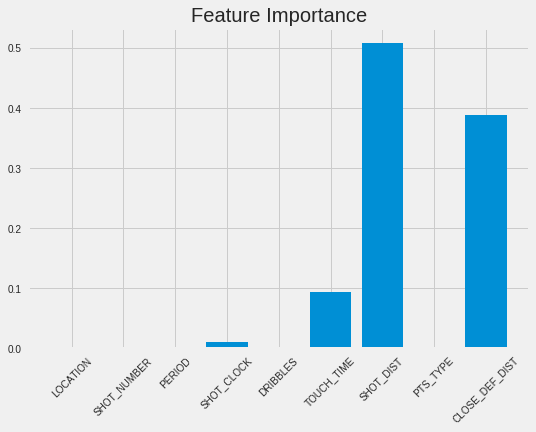

In [4]:
plt.bar(range(len(X_test.columns.values)), decision_tree.feature_importances_)
plt.xticks(range(len(X_test.columns.values)),X_test.columns.values, rotation= 45)
plt.title('Feature Importance')

It seems that the classifier primarily uses the shot distance, as well as the distance from the closest defender, which makes sense. Let's see how much we can improve the classifier by increasing the depth and using more features, before we start to overfit:

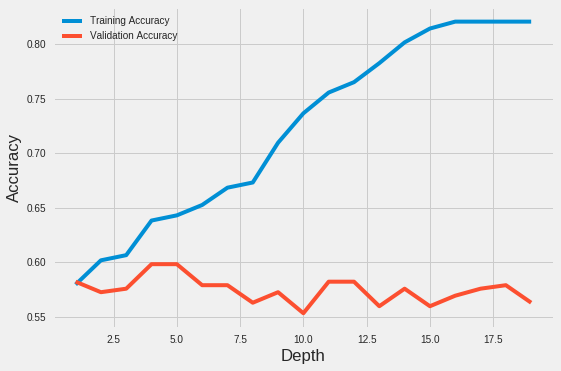

In [5]:
train_score = []
test_score = []
for depth in np.arange(1,20):
    decision_tree = tree.DecisionTreeClassifier(max_depth = depth,min_samples_leaf = 5)
    decision_tree.fit(X_train, y_train)
    train_score.append(decision_tree.score(X_train,y_train))
    test_score.append(decision_tree.score(X_test,y_test))

plt.plot(np.arange(1,20),train_score)
plt.plot(np.arange(1,20),test_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Max depth of 5 looks like a reasonable choice. Let's explore the feature importance with this configuration:

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:5:

0.59807073955


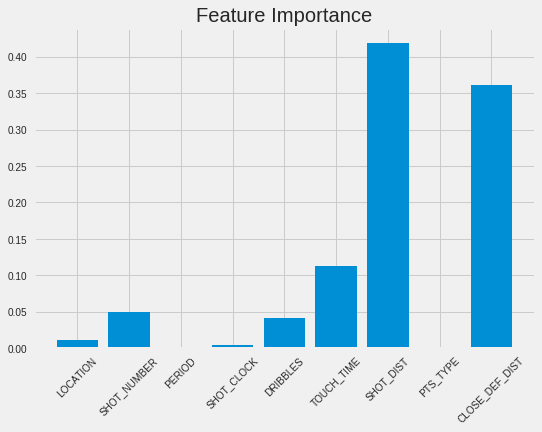

In [6]:
player_name = 'stephen curry'
player_df = shots[shots.player_name == player_name]

player_df['LOCATION'][player_df.LOCATION == 'H'] = 1
player_df['LOCATION'][player_df.LOCATION == 'A'] = 0

player_df = player_df.drop(['GAME_ID','MATCHUP','W','FINAL_MARGIN','SHOT_RESULT', 'CLOSEST_DEFENDER_PLAYER_ID','GAME_CLOCK','player_name','player_id','PTS','CLOSEST_DEFENDER'], axis = 1)
player_df = player_df[~np.isnan(player_df.SHOT_CLOCK) == True ]

X_train, X_test, y_train, y_test = train_test_split(
     player_df.drop(['FGM'], axis = 1), player_df.FGM, test_size=0.33, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth = 5,min_samples_leaf = 5)
decision_tree.fit(X_train, y_train)


y_pred = decision_tree.predict(X_test)

diff = y_pred - y_test
print(np.true_divide(len(diff[diff == 0]),len(y_test)))

plt.bar(range(len(X_test.columns.values)), decision_tree.feature_importances_)
plt.xticks(range(len(X_test.columns.values)),X_test.columns.values, rotation= 45)
plt.title('Feature Importance')

Using this very simple model we can improve the accuracy up to 60%. Which still doesn't look like a huge improvement from the random guess. 

The most important features in our model are:

 1. Shot distance
 2. Closest defender distance
 3. Touch time
 4. Shot number (this maybe interesting from the famous "Hot Hand" perspective)
 5. Number of dribbles
 6. Shot clock